In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')

# Performance of GeOpt on a binary classification task: Breast cancer diagnostic

In [2]:
import numpy as np
import sympy
sympy.init_printing()
import sklearn.datasets
X, Y = sklearn.datasets.load_breast_cancer(True)


def shuffle_arrays(X, Y):
    """
    Shuffles the first dimension of the given arrays
    returns nothing 
    """
    rnd_state = np.random.get_state()
    np.random.shuffle(X)
    np.random.set_state(rnd_state)
    np.random.shuffle(Y)


shuffle_arrays(X, Y)

n = len(X)
ntrain = int(n * .2)
x_train, y_train = X[:ntrain], Y[:ntrain]
x_test, y_test = X[ntrain:], Y[ntrain:]

print('train size: %s/%s samples' % (ntrain, n))

from geopt.metrics import *


def fit(tree):
    pred = tree.evaluate(*x_train.T)[0]
    if np.isnan(pred).any():
        return float('-inf')
    return roc_auc_score(y_train, pred)

train size: 113/569 samples



Area under ROC curve for training data: 0.990365448505



Area under ROC curve for training data: 1.0


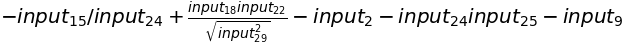

In [3]:
from geopt import Evolution
from geopt import operations
from tqdm import tnrange


E = Evolution(30, 100, 1, popsize=20, bestsize=3,
              newgen=5, ops=operations.ops)


pop = E.bestpop(10, 10, fit, .3, range=tnrange)

print('Area under ROC curve for training data:', fit(pop[0]))
for _ in tnrange(50):
    pop = E.evolve(pop, fit, None)
print('Area under ROC curve for training data:', fit(pop[0]))
t = pop[0]
t.expr[0]

In [4]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [16, 8]
import matplotlib.pyplot as plt

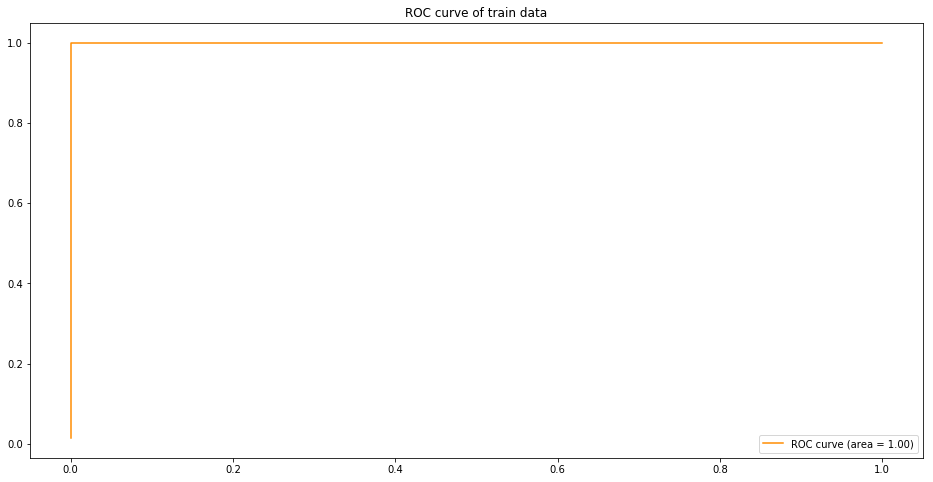

In [5]:
pred = t.evaluate(*x_train.T)[0]
fpr, tpr, thresholds = roc_curve(y_train, pred)
plt.title('ROC curve of train data')
plt.plot(fpr, tpr, color='darkorange',
         label='ROC curve (area = %0.2f)' % roc_auc_score(y_train, pred))
plt.legend(loc="lower right")
plt.show()

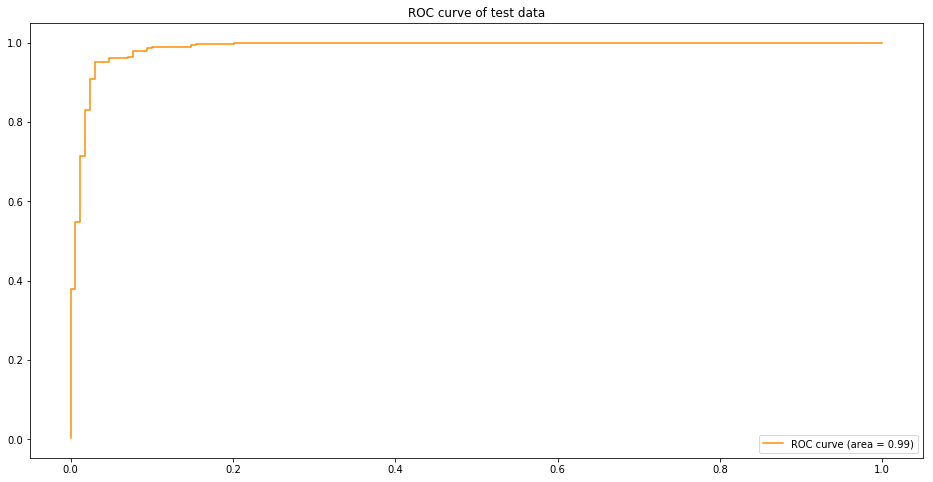

In [6]:
pred = t.evaluate(*x_test.T)[0]
fpr, tpr, thresholds = roc_curve(y_test, pred)
plt.title('ROC curve of test data')
plt.plot(fpr, tpr, color='darkorange',
         label='ROC curve (area = %0.2f)' % roc_auc_score(y_test, pred))
plt.legend(loc="lower right")
plt.show()

In [7]:
print(accuracy(t.evaluate(*x_test.T) >=
               optimum_threshold(y_train, t.evaluate(*x_train.T)[0]), y_test))

0.947368421053


# Ensemble learning

In [8]:
classifier_number = 5

ens = [max(E.evolvepop(50, E.bestpop(10, 10, fit, .3), fit, None), key=fit) for _ in tnrange(classifier_number)]
ens_ths = [optimum_threshold(y_train, t.evaluate(*x_train.T)[0]) for t in ens]

In [9]:
def evaluate(ens, ens_ths, X):
    return np.array([t.evaluate(*X.T)[0] >= th for t, th in zip(ens, ens_ths)]).mean(axis=0)

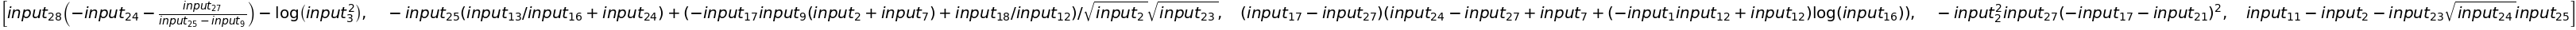

In [10]:
[e.expr[0] for e in ens]

In [11]:
print('Accuracy of each one')
[accuracy(evaluate([t], [th], x_test) >= .5, y_test) for t, th in zip(ens, ens_ths)]

Accuracy of each one


In [12]:
from collections import Counter
print('Frequencies of the votes:')
Counter(evaluate(ens, ens_ths, x_test))

Frequencies of the votes:


In [13]:
print('Accuracy of the group')
accuracy(evaluate(ens, ens_ths, x_test) >= .5, y_test)

Accuracy of the group
